In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont, Gauss_dist
from spec_exam import Gen_spec
from spec_id import *
from sim_engine import *
from spec_stats import Highest_density_region, Linear_fit
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from prospect.models.transforms import logsfr_ratios_to_masses
from time import time
import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [11]:
goodss_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodsn_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodss_eazy = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                         format='fits').to_pandas()
goodsn_eazy = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                         format='fits').to_pandas()

In [17]:
int(os.path.basename(llist[0]).split('_')[1])

12078

In [18]:
Reff = []
lmass = []
rshift = []
llist = glob('../data/posteriors/G*_tabfit_Plm.npy')
zlist = glob('../data/posteriors/G*_tabfit_Plm.npy')

for i in range(len(zlist)):
    x,px = np.load(zlist[i])
    rshift.append(x[px==px.max()][0])
    x,px = np.load(llist[i])
    lmass.append(x[px==px.max()][0])
    
    ids = int(os.path.basename(llist[0]).split('_')[1])

    if os.path.basename(llist[0]).split('_')[0][1] == 'S':
        r = goodss_rad.re[goodss_rad.NUMBER == ids].values * np.sqrt(goodss_rad.q[goodss_rad.NUMBER == ids].values)
        Reff.append(r[0])
        
    if os.path.basename(llist[0]).split('_')[0][1] == 'N':
        r = goodsn_rad.re[goodsn_rad.NUMBER == ids].values * np.sqrt(goodsn_rad.q[goodsn_rad.NUMBER == ids].values)
        Reff.append(r[0])


In [6]:
G_gals = pd.DataFrame({'field':fields, 'id':ids, 'zgrism':rshift, 'mass':lmass, 'lmass':np.log10(lmass)})

# Examine fits

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-1.31, 0.5)

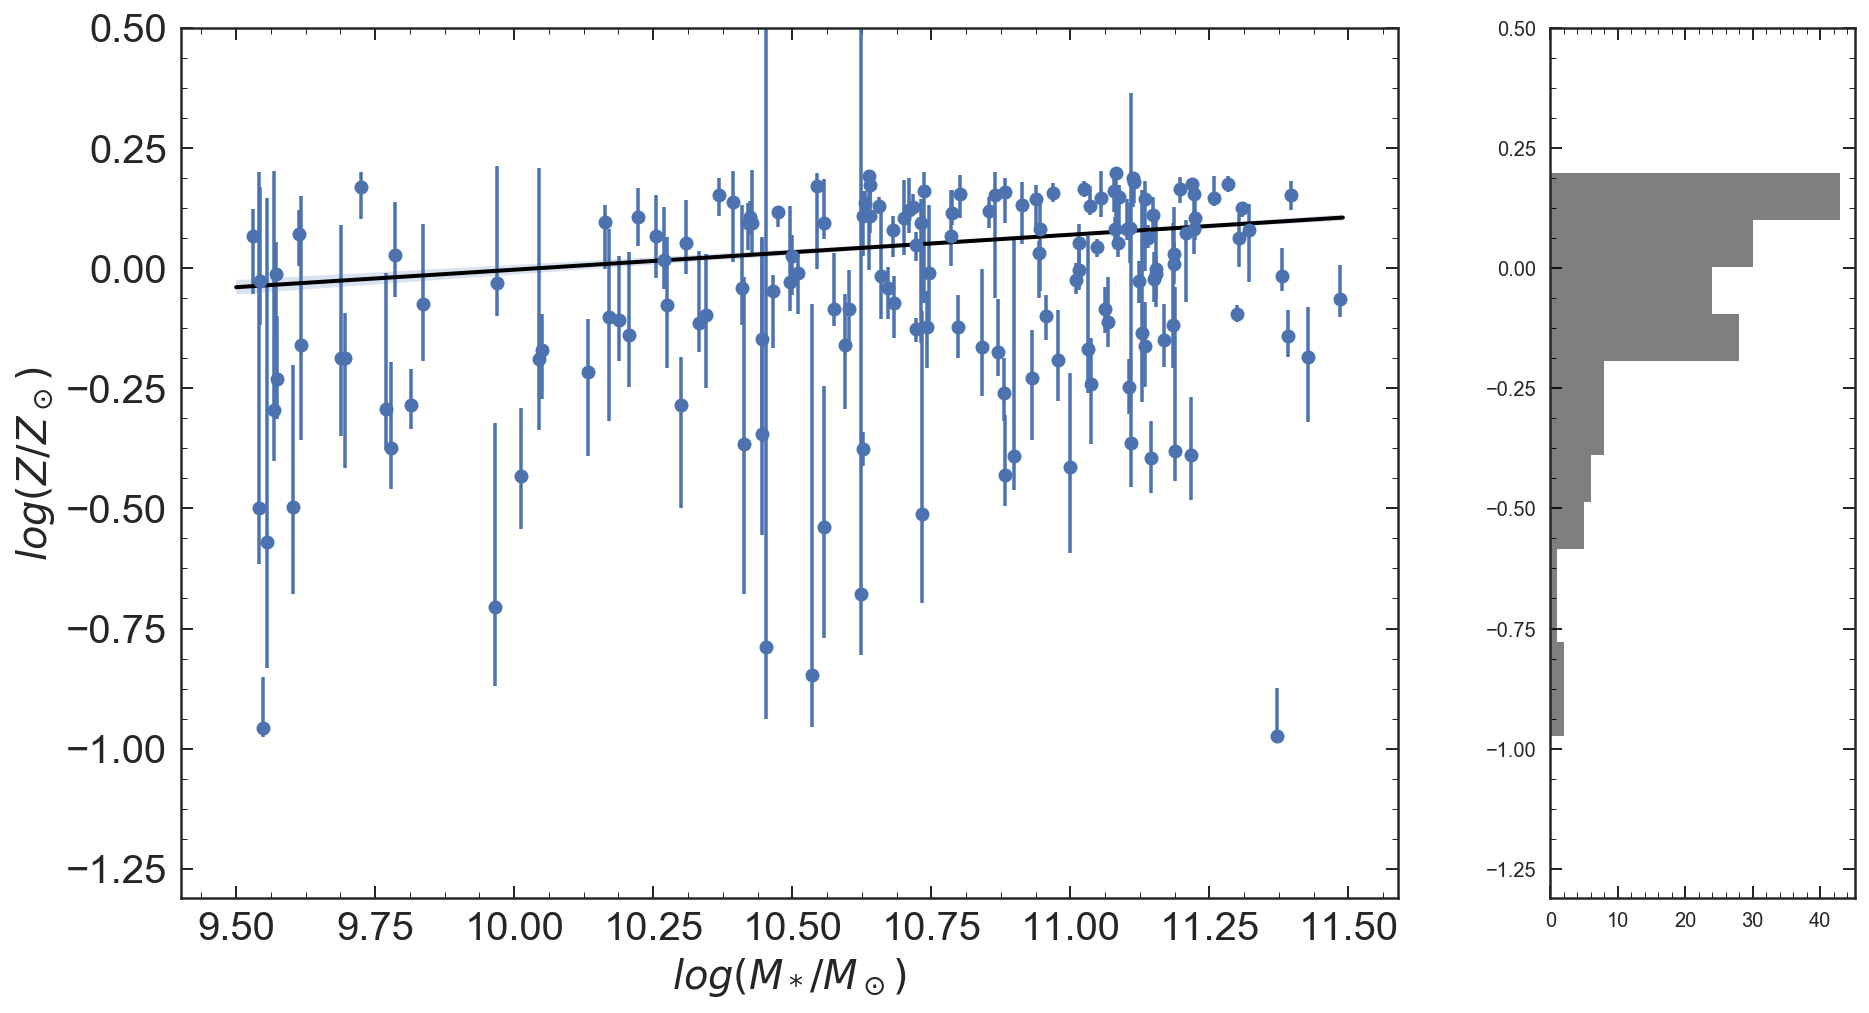

In [57]:
plist = glob('../data/posteriors/G*_tabfit_Pm.npy')
llist = glob('../data/posteriors/G*_tabfit_Plm.npy')

tmed,tle,the = np.zeros([3,len(plist)])
dmed,dle,dhe = np.zeros([3,len(plist)])

gs= GridSpec(1,2,width_ratios=[4,1])

plt.figure(figsize=[15,8])
plt.subplot(gs[0])

for i in range(len(plist)):
    t,pt = np.load(plist[i])
    d,pd = np.load(llist[i])
    tmed[i],tle[i],the[i] = Highest_density_region(pt,t)
    dmed[i],dle[i],dhe[i] = Highest_density_region(pd,d)

plt.errorbar(dmed,np.log10(tmed), yerr=[tle / (tmed*np.log(10)),the/ (tmed*np.log(10))], fmt='o')
plt.ylim(-1.31,.5)

    
errs = ((tle + the)/2) / (tmed * np.log(10))
samp = np.arange(9.5,11.5,.01)
lfit,lfit_errs,cov = Linear_fit(dmed,np.log10(tmed),errs,samp,return_cov=True)

plt.plot(samp,lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,lfit - lfit_errs,lfit + lfit_errs,alpha = .2,label = '68% Conifidence Interval')
plt.xlabel('$log(M_*/M_\odot)$', fontsize=20)
plt.ylabel('$log(Z/Z_\odot)$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.subplot(gs[1])
sea.distplot(np.log10(tmed),
             vertical=True,kde=False,hist_kws={"histtype": "stepfilled", "linewidth": 3,"alpha": 0.5,"color":'k'})
plt.ylim(-1.31,.5)

# plt.savefig('../plots/new_MM.png' ,bbox_inches = 'tight')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


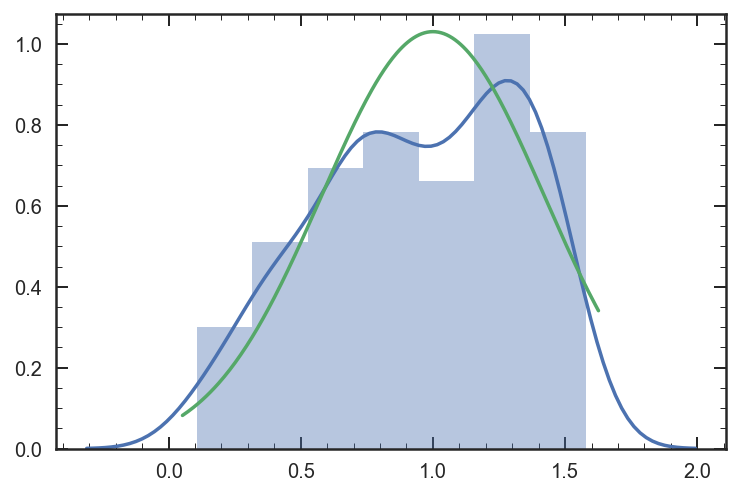

In [70]:
x = np.arange(0.001,0.031,0.0001) / 0.019

sea.distplot(tmed)
plt.plot(x, Gauss_dist(x , 1, 0.008/0.019))

In [ ]:
x

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-1.31, 0.5)

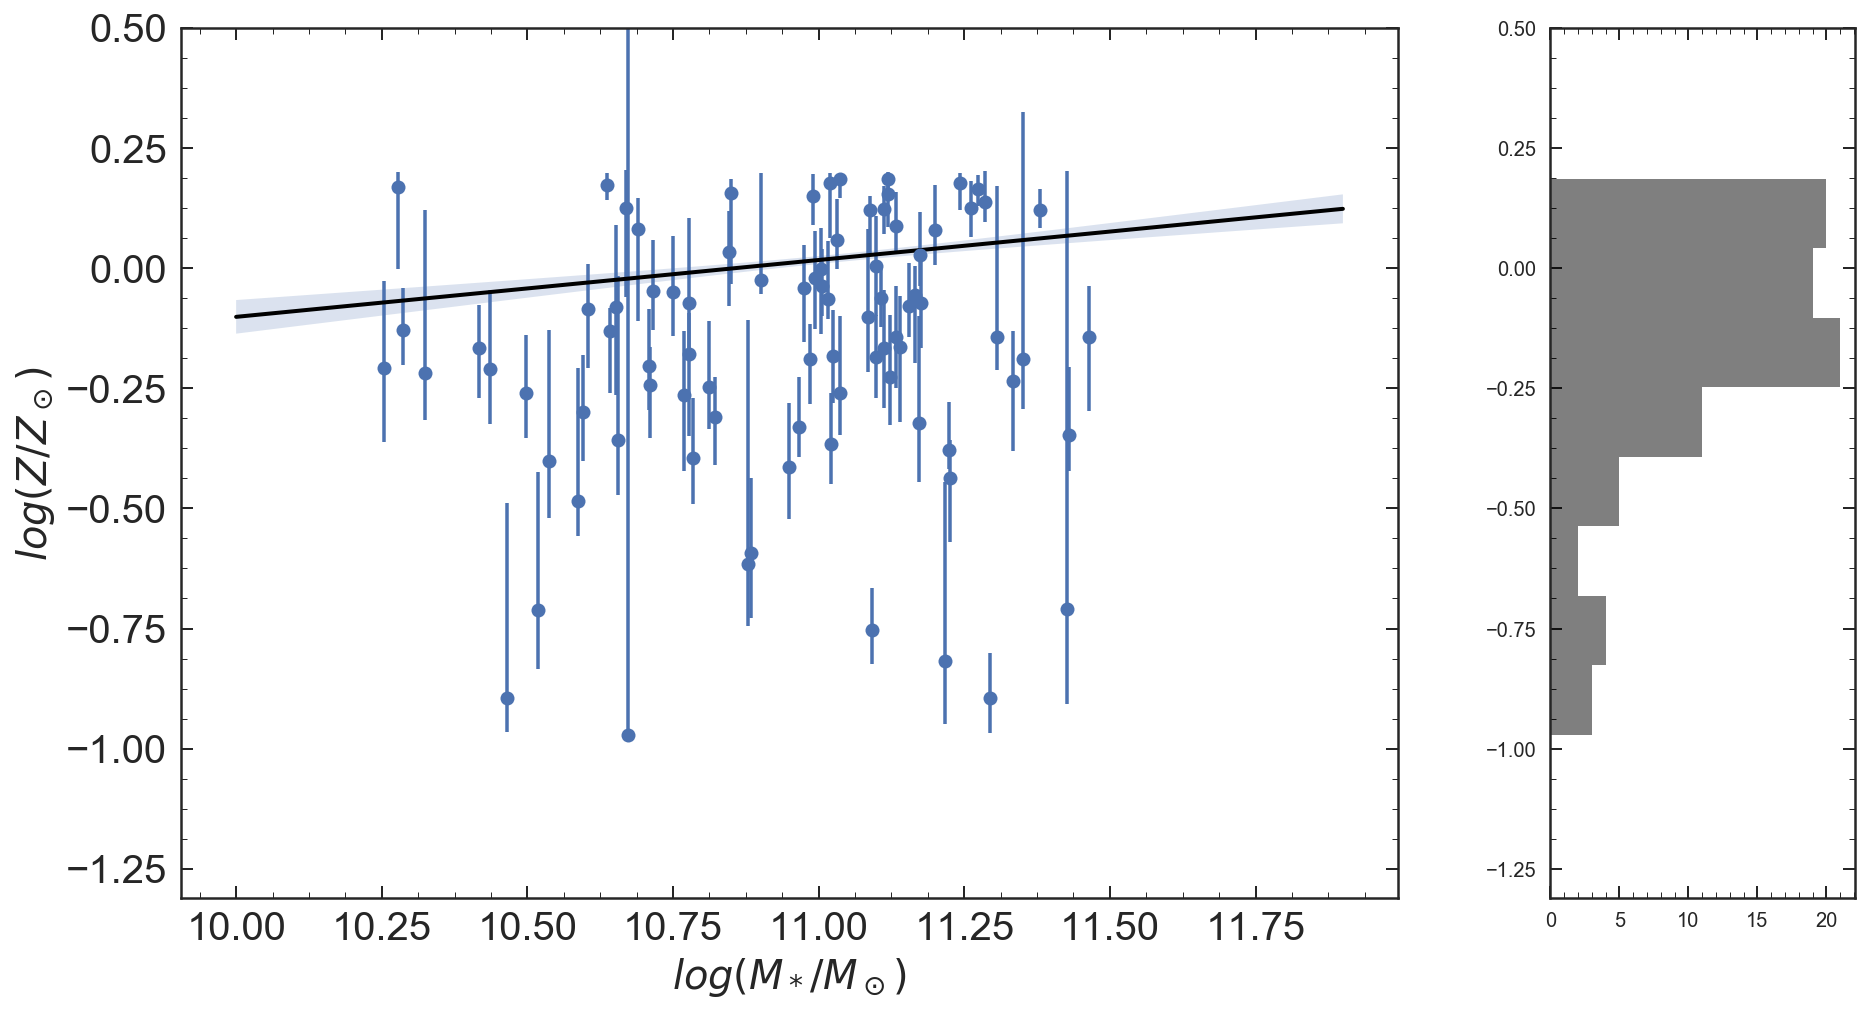

In [55]:
plist = glob('../data/posteriors/G*_delayfit_Pm.npy')
llist = glob('../data/posteriors/G*_delayfit_Plm.npy')

tmed,tle,the = np.zeros([3,len(plist)])
dmed,dle,dhe = np.zeros([3,len(plist)])

gs= GridSpec(1,2,width_ratios=[4,1])

plt.figure(figsize=[15,8])
plt.subplot(gs[0])

for i in range(len(plist)):
    t,pt = np.load(plist[i])
    d,pd = np.load(llist[i])
    tmed[i],tle[i],the[i] = Highest_density_region(pt,t)
    dmed[i],dle[i],dhe[i] = Highest_density_region(pd,d)

plt.errorbar(dmed,np.log10(tmed), yerr=[tle / (tmed*np.log(10)),the/ (tmed*np.log(10))], fmt='o')
plt.ylim(-1.31,.5)

    
errs = ((tle + the)/2) / (tmed * np.log(10))
samp = np.arange(10,11.9,.01)
lfit,lfit_errs,cov = Linear_fit(dmed,np.log10(tmed),errs,samp,return_cov=True)

plt.plot(samp,lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,lfit - lfit_errs,lfit + lfit_errs,alpha = .2,label = '68% Conifidence Interval')
plt.xlabel('$log(M_*/M_\odot)$', fontsize=20)
plt.ylabel('$log(Z/Z_\odot)$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.subplot(gs[1])
sea.distplot(np.log10(tmed),
             vertical=True,kde=False,hist_kws={"histtype": "stepfilled", "linewidth": 3,"alpha": 0.5,"color":'k'})
plt.ylim(-1.31,.5)

# plt.savefig('../plots/new_MM.png' ,bbox_inches = 'tight')

(0, 8)

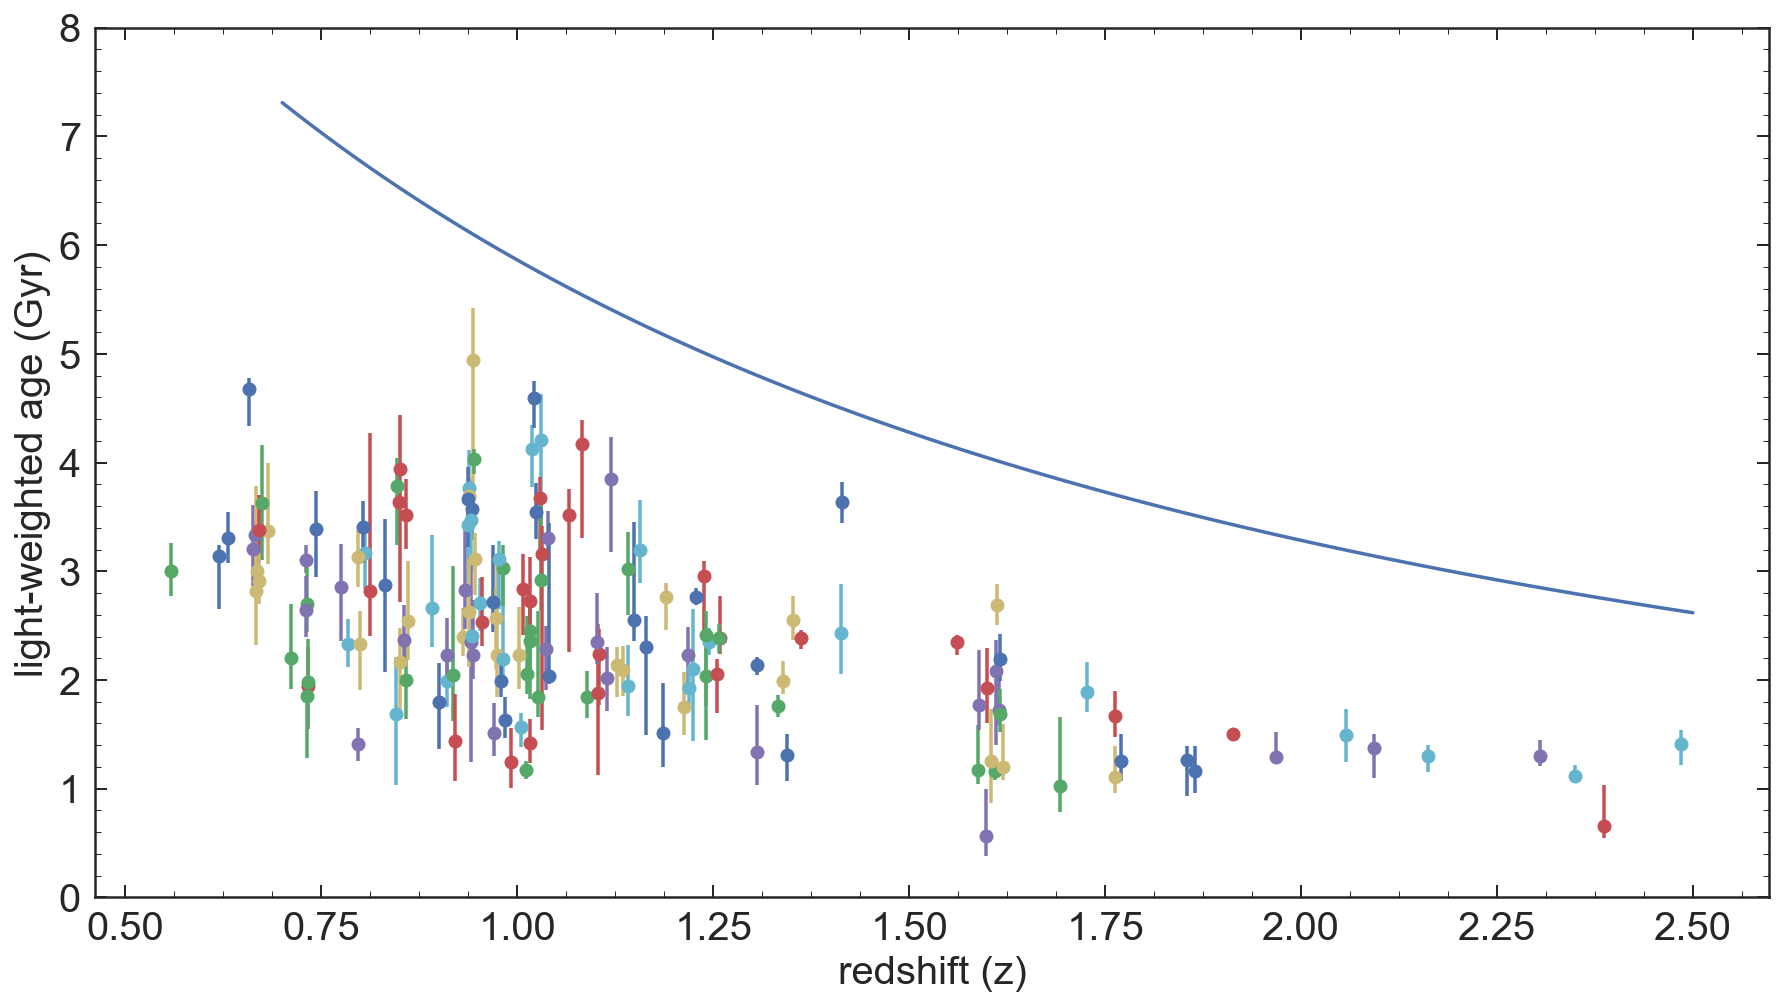

In [72]:
plist = glob('../data/posteriors/G*_tabfit_Plwa.npy')
llist = glob('../data/posteriors/G*_tabfit_Pz.npy')

z=np.linspace(0.7,2.5,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[15,8])

plt.plot(z,ages)

for i in range(len(plist)):
    t,pt = np.load(plist[i])
    d,pd = np.load(llist[i])
    tmed,tle,the = Highest_density_region(pt,t)
    dmed,dle,dhe = Highest_density_region(pd,d)

    plt.errorbar(dmed,tmed, yerr=[[tle],[the]], fmt='o')
    
plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(0,8)
# plt.savefig('../plots/new_lwa.png' ,bbox_inches = 'tight')


In [73]:
len(plist)

158

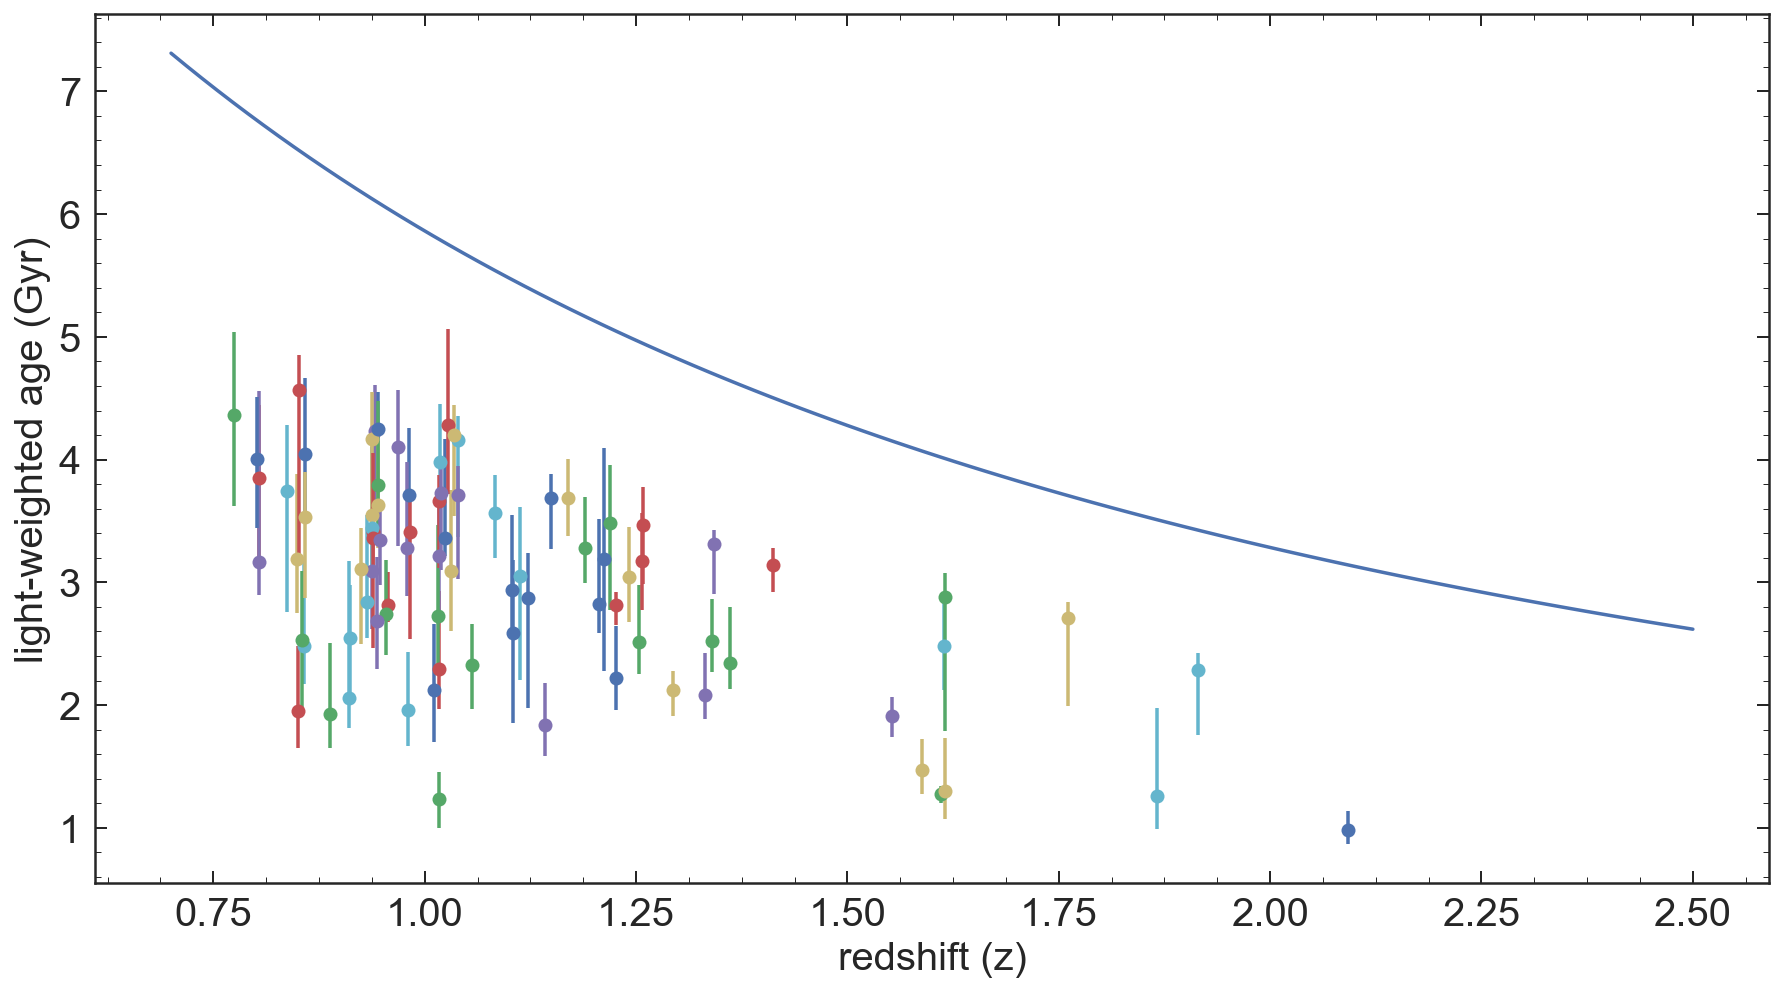

In [109]:
plist = glob('../data/posteriors/G*_delayfit_Plwa.npy')
llist = glob('../data/posteriors/G*_delayfit_Pz.npy')

z=np.linspace(0.7,2.5,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[15,8])

plt.plot(z,ages)

for i in range(len(plist)):
    t,pt = np.load(plist[i])
    d,pd = np.load(llist[i])
    tmed,tle,the = Highest_density_region(pt,t)
    dmed,dle,dhe = Highest_density_region(pd,d)

    plt.errorbar(dmed,tmed, yerr=[[tle],[the]], fmt='o')
    
plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/new_lwa.png' ,bbox_inches = 'tight')

In [2]:

def PLOT(field, galaxy, savefig = False):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))
    
    Gs = Gen_spec(field, galaxy, z, phot_errterm = 0.04, irac_err = 0.08) 
    wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)    

    Gs.Best_fit_scale(wave, flux, z, bp1, rp1, sp.stellar_mass, lm)
    
    gs = GridSpec(3,4, hspace=0.3, wspace = 0.3)   

    plt.figure(figsize=[16,15])
    ###############plot tab##################
    plt.subplot(gs[0,:3])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.title(galaxy, fontsize=25)
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############sfh plot################
    med,le,he = np.zeros([3,10])
    for i in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(field, galaxy,i+1))
        med[i],le[i],he[i] = Highest_density_region(px,x)

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(field, galaxy))
    a,ale,ahe = Highest_density_region(px,x)

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    time, sfr_l, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
    time, sfr_h, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9) 
    
    plt.subplot(gs[0,3])
    plt.plot(time,sfr, 'r')
    plt.fill_between(time,sfr_l, sfr_h, alpha = 0.3)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('SFR', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############plot delay################
    m, a, tau, lm, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_delayfit_bfit.npy'.format(field, galaxy))
    
        
    Gs = Gen_spec(field, galaxy, z, phot_errterm = 0.04, irac_err = 0.08) 
    
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, tau = 0.01, dust_type = 1)
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    sp.params['tau'] = tau
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)    

    Gs.Best_fit_scale(wave, flux, z, bp1, rp1, sp.stellar_mass, lm)

    plt.subplot(gs[1,:3])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############sfh plot################
    x,px = np.load('../data/posteriors/{0}_{1}_delayfit_Pt.npy'.format(field, galaxy))
    tau, taul, tauh = Highest_density_region(px,x)

    x,px = np.load('../data/posteriors/{0}_{1}_delayfit_Pa.npy'.format(field, galaxy))
    a,ale,ahe = Highest_density_region(px,x)

    t = np.arange(0,a,0.01)
    sfr = t*np.exp( -t / tau) / np.trapz(t*np.exp( -t / tau),t)
    sfrl = t*np.exp( -t /(tau - taul)) / np.trapz(t*np.exp( -t /(tau - taul)),t)
    sfrh = t*np.exp( -t / (tau + tauh)) /  np.trapz(t*np.exp( -t / (tau + tauh)),t)
   
    plt.subplot(gs[1,3])
    plt.plot(t,sfr,'b')
    plt.fill_between(t,sfrl, sfrh, alpha = 0.3)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('SFR', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(Z)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pm.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_delayfit_Pm.npy'.format(field, galaxy))
    
    plt.subplot(gs[2,0])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('Z / Z$_\odot$', fontsize=15)
    plt.ylabel('P(Z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(lwa)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_delayfit_Plwa.npy'.format(field, galaxy))

    plt.subplot(gs[2,1])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('P(lwa)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(z)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_delayfit_Pz.npy'.format(field, galaxy))
    
    plt.subplot(gs[2,2])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('redshift', fontsize=15)
    plt.ylabel('P(z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(d)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pd.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_delayfit_Pd.npy'.format(field, galaxy))
    
    plt.subplot(gs[2,3])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('Av', fontsize=15)
    plt.ylabel('P(Av)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    
    if savefig:
        plt.savefig('../plots/fullfits/all_data_{0}_{1}.png'.format(field, galaxy),bbox_inches = 'tight')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/minico

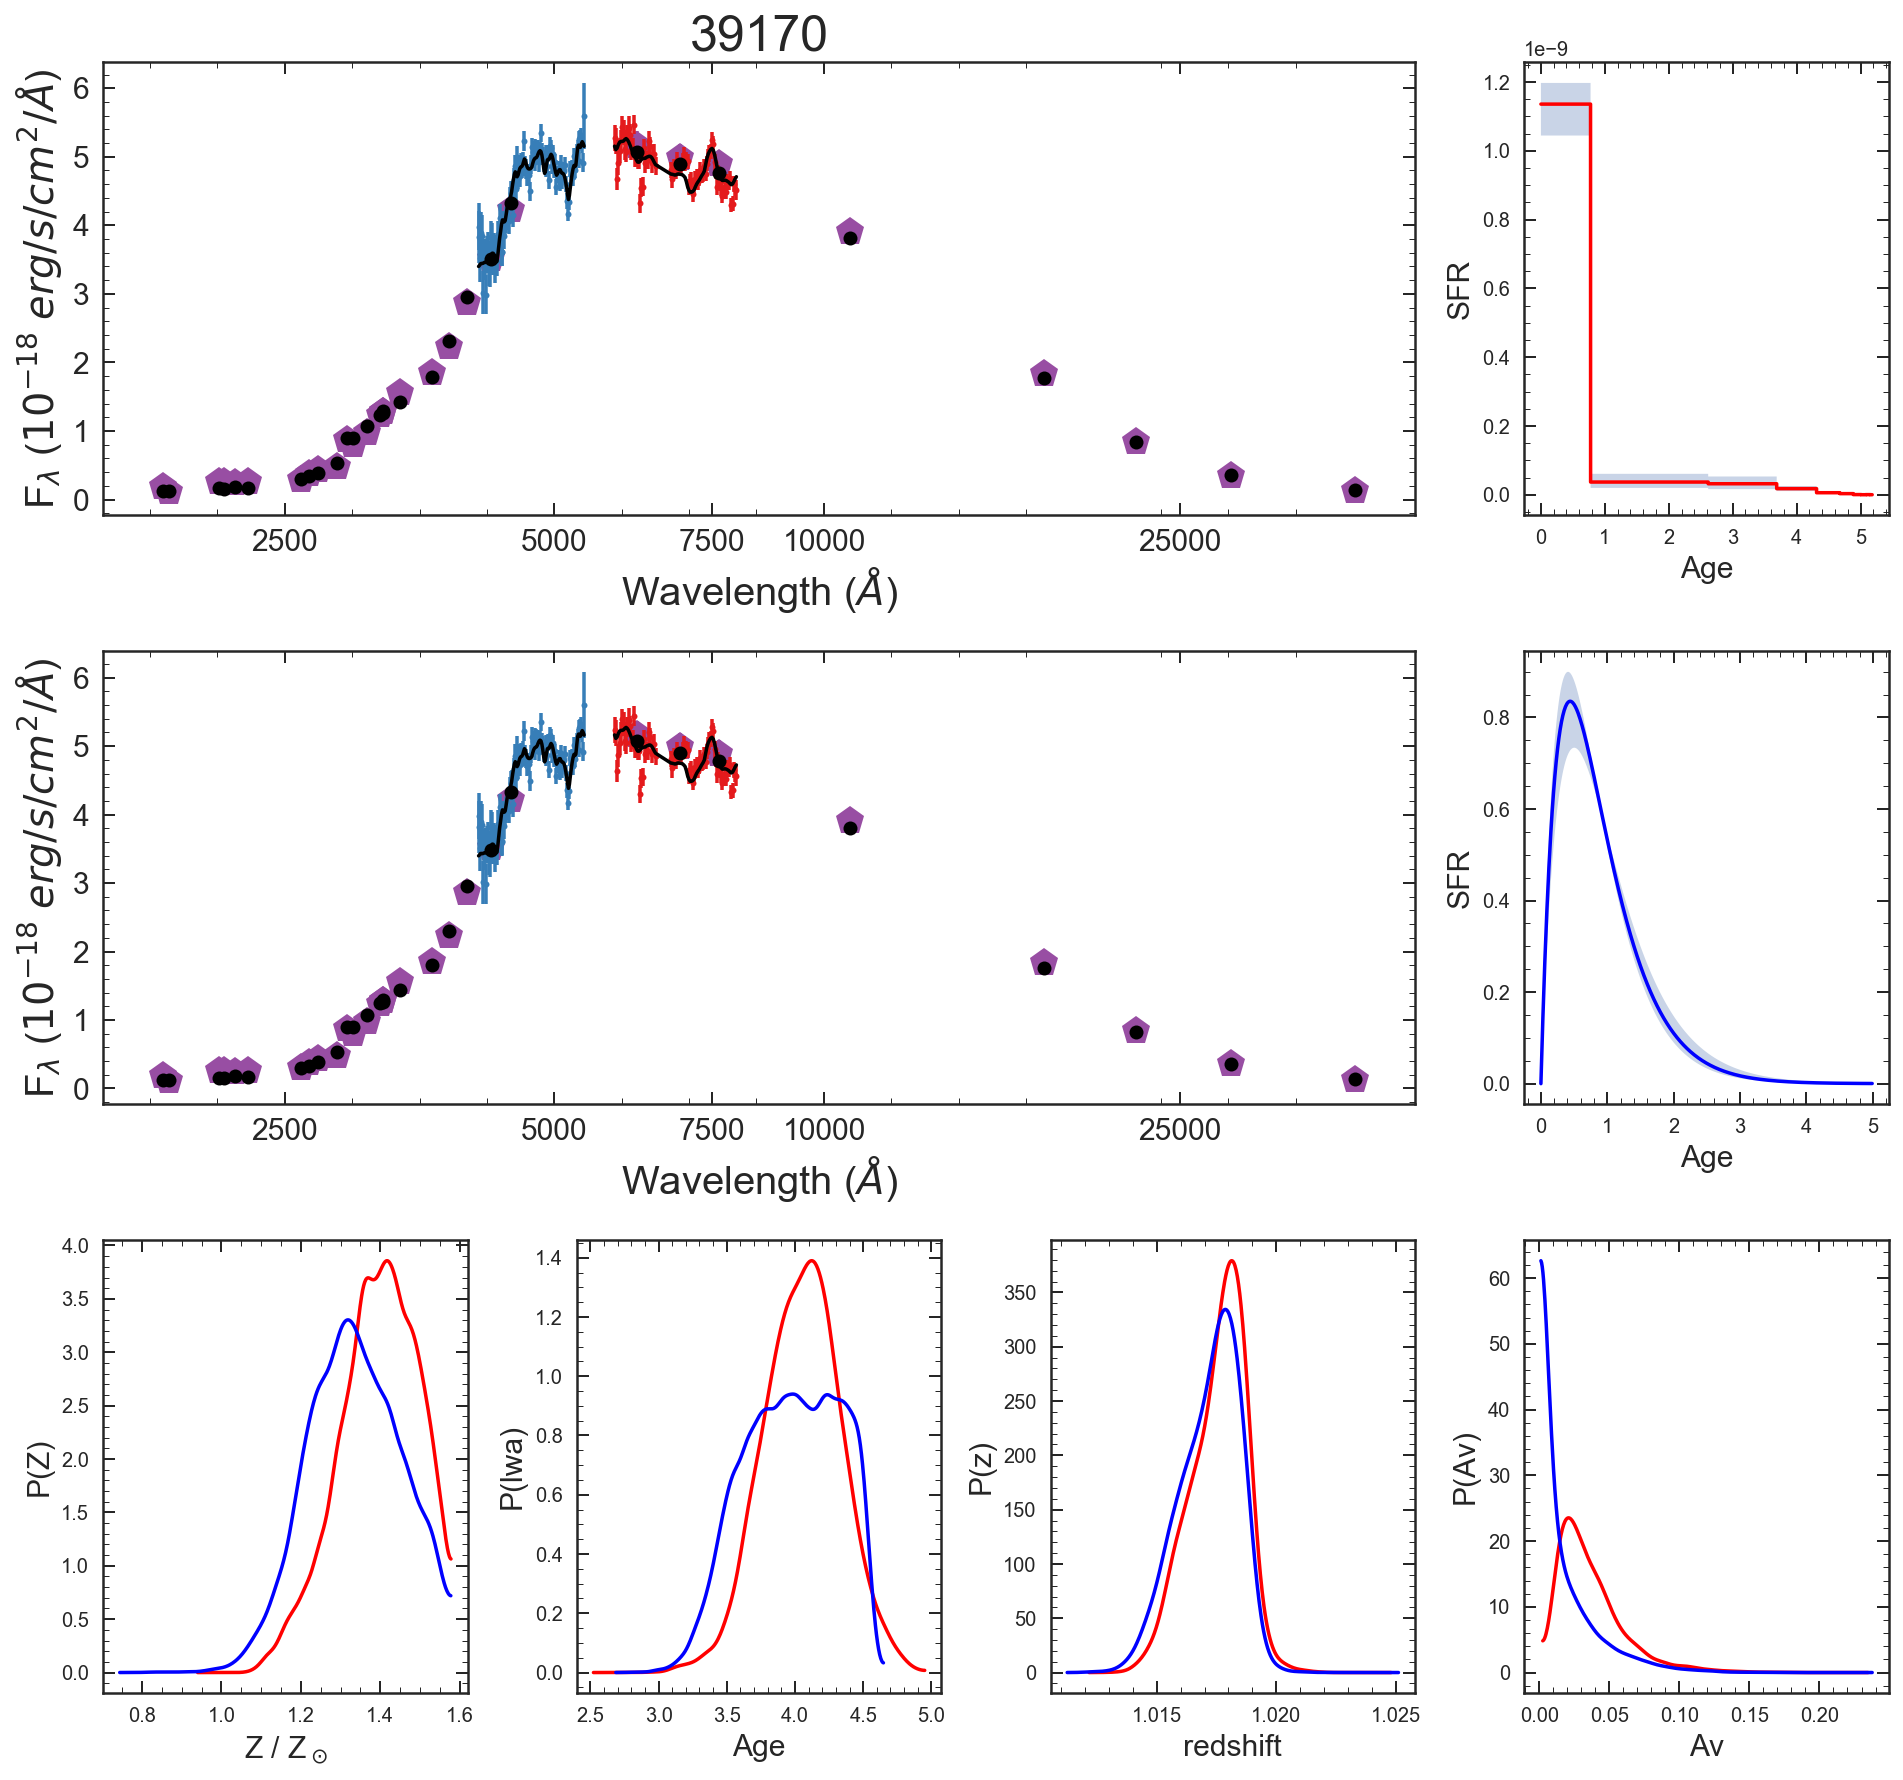

In [3]:
PLOT('GSD', 39170, savefig=False)

In [101]:
field = 'GND'
galaxy = 21156

m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, bsc, rsc, \
bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
    '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))

Gs = Gen_spec(field, galaxy, z, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
    phot_errterm = 0.04, irac_err = 0.08, decontam = True) 

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
sp.params['dust2'] = d
sp.params['dust1'] = d
sp.params['logzsol'] = np.log10(m)

time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

sp.set_tabular_sfh(time,sfr)    

wave, flux = sp.get_spectrum(tage = a, peraa = True)    

wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

# Gs.Sim_all_premade(wave*(1+z),flux)

Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm, z, 
                                    wvs, flxs, errs, beams, trans)
       
Gmfl = Full_calibrate(Gmfl, [bp1, rp1], [bsc, rsc], wvs)

Gmfl2, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm, z, 
                                    wvs, flxs, errs, beams, trans)

# if Gs.g102:
#     bcal = Calibrate_grism([wvs[0],flxs[0],errs[0]], Gmfl[0], bp1)[0]

# if Gs.g141:
#     rcal = Calibrate_grism([wvs[1],flxs[1],errs[1]], Gmfl[1], rp1)[0]

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [98]:
bsc, rsc, bp1, rp1

(1.0403325574425943,
 0.9966575370326397,
 -0.026294564079008296,
 -0.0014591368442415738)

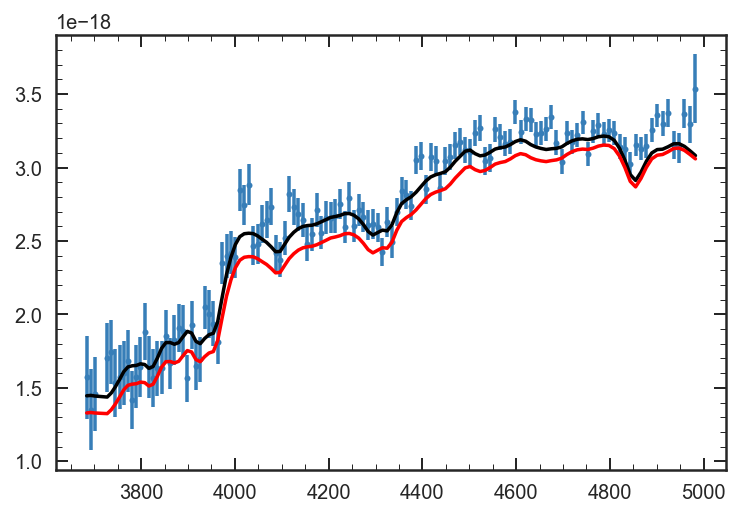

In [105]:
plt.errorbar(Gs.Bwv_rf,flxs[0],errs[0],
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
plt.plot(Gs.Bwv_rf,Gmfl[0],'k', zorder = 4)
plt.plot(Gs.Bwv_rf,Gmfl2[0],'r', zorder = 4)

# plt.errorbar(Gs.Rwv_rf,flxs[1],errs[1],
#             linestyle='None', marker='o', markersize=3, color='r', zorder = 2)
# plt.plot(Gs.Rwv_rf,Gmfl[1],'k', zorder = 4)

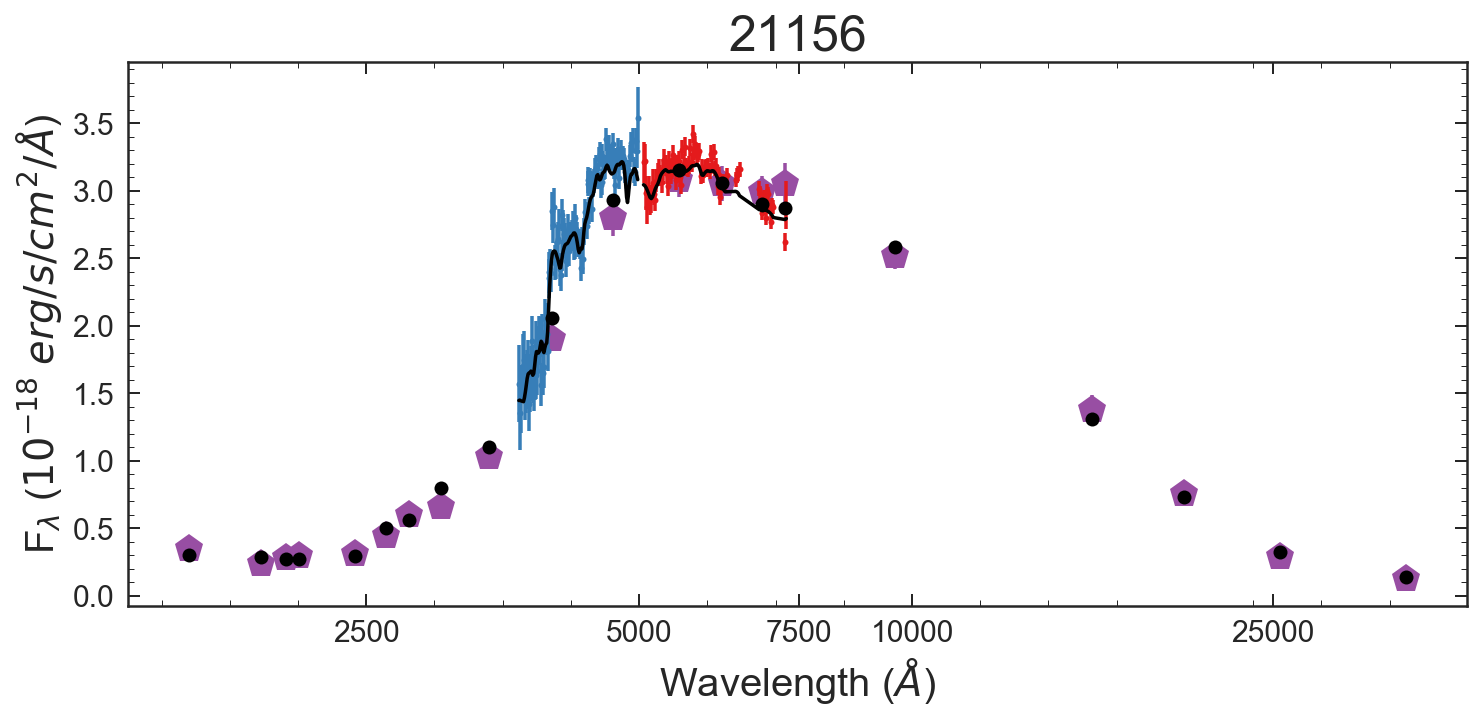

In [75]:
plt.figure(figsize=[12,5])
###############plot tab##################
# scale = Scale_model(flxs[0]/ bcal, errs[0]/ bcal, Gmfl[0])

if Gs.g102:
    plt.errorbar(np.log10(Gs.Bwv_rf),flxs[0]*1E18 ,errs[0]*1E18 ,
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
    plt.plot(np.log10(Gs.Bwv_rf),Gmfl[0]*1E18,'k', zorder = 4)

if Gs.g141:
    plt.errorbar(np.log10(Gs.Rwv_rf),flxs[1]*1E18 ,errs[1]*1E18 ,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
    plt.plot(np.log10(Gs.Rwv_rf),Gmfl[1]*1E18,'k', zorder = 4)

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
plt.plot(np.log10(Gs.Pwv_rf),Pmfl*1E18,'ko', zorder = 3)
plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
plt.title(galaxy, fontsize=25)
plt.xlabel('Wavelength ($\AA$)', fontsize=20)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)


1.0236926518531981


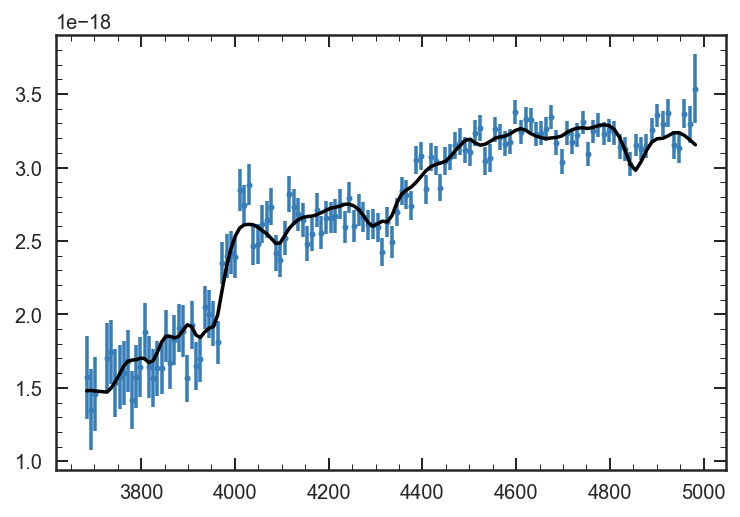

In [65]:

scale = Scale_model(flxs[0], errs[0], Gmfl[0])
print(scale)
plt.errorbar(Gs.Bwv_rf,flxs[0],errs[0],
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
plt.plot(Gs.Bwv_rf,Gmfl[0] * scale,'k', zorder = 4)

In [2]:
flist = glob('../data/posteriors/*zfit*')

fld = [os.path.basename(U).split('_')[0] for U in flist] 
ids = np.array([os.path.basename(U).split('_')[1] for U in flist]).astype(int)

In [3]:
for i in range(len(fld)):
    PLOT(fld[i], [i], savefig=True)

array([12078, 12793, 13182, 13774, 14158, 14713, 15490, 15901, 16758,
       17070, 17194, 17436, 20432, 21156, 22213, 22246, 22633, 23081,
       23104, 23459, 23490, 23631, 23758, 24177, 24795, 26673, 27185,
       27458, 27714, 27951, 29464, 30358, 32108, 33453, 33780, 34694,
       36102, 36161, 36348, 36530, 37180, 37186, 37189, 37210, 37232,
       37340, 37686, 37813, 37955, 18642, 19148, 23421, 25641, 26139,
       26915, 30144, 31397, 32799, 35046, 35774, 36095, 38191, 38472,
       38785, 39170, 39241, 39364, 39631, 39804, 39805, 39850, 40476,
       40597, 40623, 40862, 41148, 41520, 41886, 42113, 42221, 43615,
       44042, 44620, 44946, 45775, 45789, 45972, 47223, 47677, 47691,
       48631])

## Sample from posteriors

In [8]:
def Gen_PPF(x,px):
    return interp1d(np.cumsum(px) / np.cumsum(px).max(),x)

In [12]:
ppf_dict = {}
params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'z', 'd', 'bp1', 'rp1']

for i in params:
    x,px = np.load('../data/posteriors/GND_21156_tabfit_P{0}.npy'.format(i))
    ppf_dict[i] = Gen_PPF(x,px)
    

In [13]:
x,px = np.load('../data/posteriors/GND_21156_tabfit_Pz.npy')
x[px == px.max()]

array([1.25352094])

In [14]:
Gs = Gen_spec('GND', 21156, 1.255, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False, phot_errterm = 0.04, 
              irac_err = 0.08, decontam = True) 
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [6]:
def Calibrate_grism(spec, Gmfl, p1):
    lines = (p1 * (spec[0] -(spec[0][-1] + spec[0][0])/2 ) + 1E3)
    scale = Scale_model(spec[1]  / lines, spec[2] / lines, Gmfl)    
    return scale * lines

ValueError: A value in x_new is below the interpolation range.

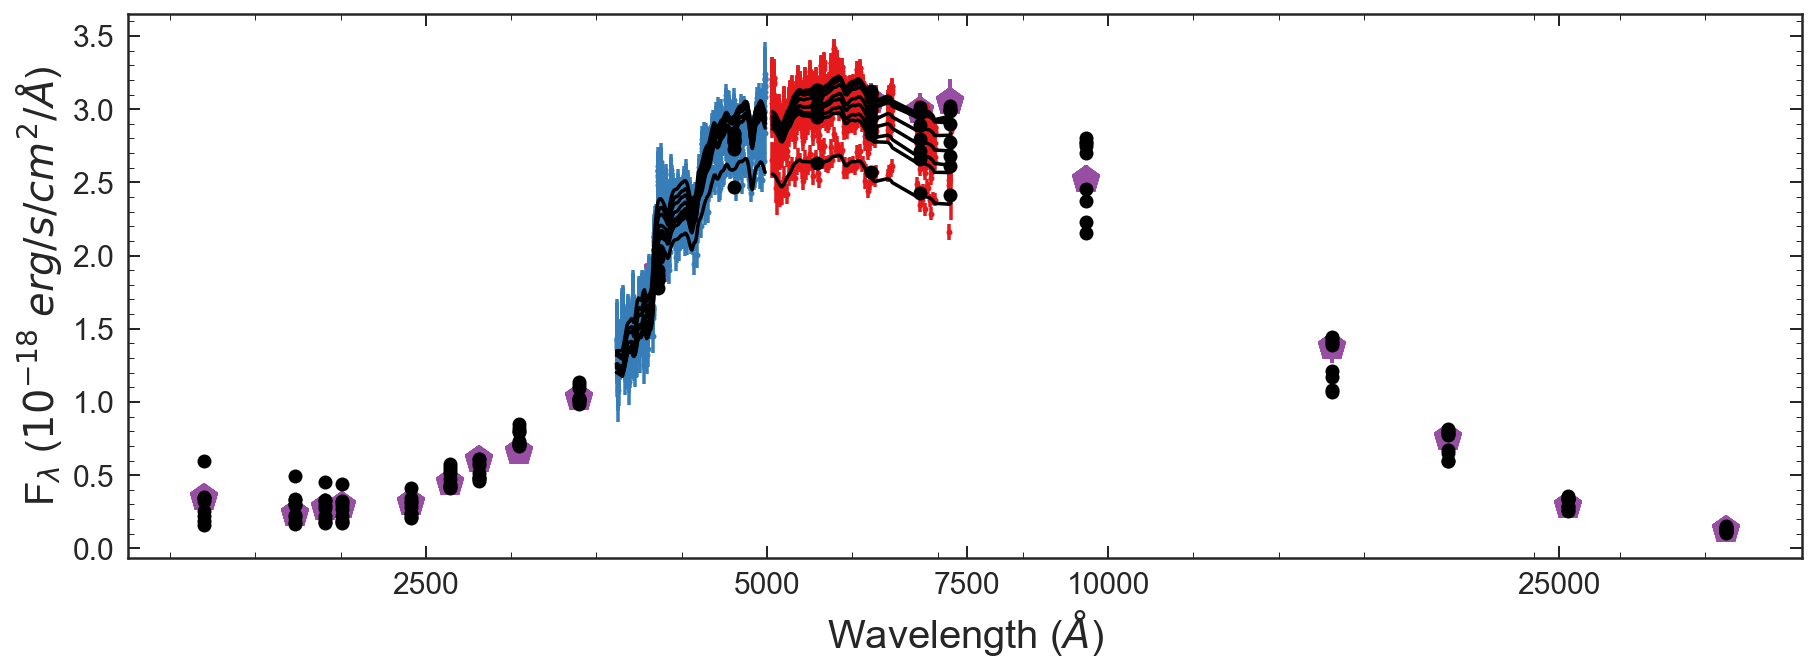

In [15]:

plt.figure(figsize=[15,5])

for u in range(50):
    draw = np.zeros(len(params))

    for i in range(len(draw)):
        draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

    sp.params['dust2'] = draw[13]
    sp.params['dust1'] = draw[13]
    sp.params['logzsol'] = np.log10(draw[0])

    time, sfr, tmax = convert_sfh(get_agebins(draw[1]), draw[2:12], maxage = draw[1]*1E9)

    sp.set_tabular_sfh(time,sfr)    

    wave, flux = sp.get_spectrum(tage = draw[1], peraa = True)    

    Gs.Sim_all_premade(wave*( 1 + draw[12]),flux)
    
#     gcal = Calibrate_grism(Gs, [Gs.Bmfl,Gs.Rmfl], [draw[14],draw[15]], [Gs.Bwv,Gs.Rwv], [Gs.Bfl,Gs.Rfl], [Gs.Ber,Gs.Rer])
    
    gs = GridSpec(2,4, hspace=0.3, wspace = 0.3)   

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18,Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl*1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 ,Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl*1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

# Create goodness dataframe

In [46]:
flist = glob('../data/posteriors/*tabfit_Pz*')

fld = [os.path.basename(U).split('_')[0] for U in flist] 
ids = np.array([os.path.basename(U).split('_')[1] for U in flist]).astype(int)

In [2]:
GNdb = pd.read_pickle('../dataframes/galaxy_frames/GN_new.pkl')
GSdb = pd.read_pickle('../dataframes/galaxy_frames/GS_new.pkl')

In [8]:
GNdb['field'] = np.repeat('GND',len(GNdb))
GSdb['field'] = np.repeat('GSD',len(GSdb))

In [11]:
GNdb = GNdb.query('AGN != "AGN"')
GSdb = GSdb.query('AGN != "AGN"')

In [12]:
ALLdb = pd.concat([GNdb,GSdb])

In [16]:
USE = np.repeat(True, len(ALLdb))
Bllim = np.repeat(0, len(ALLdb))
Bhlim = np.repeat(1E10, len(ALLdb))
Rllim = np.repeat(0, len(ALLdb))
Rhlim = np.repeat(1E10, len(ALLdb))

In [25]:
fld = ALLdb.field.values
ids = ALLdb.id.values

In [26]:
len(fld)

118

In [413]:
ALLdb.query('id == 42548')

,dec,id,ra,zphot,AGN,new,field
72,-27.712366,42548,53.149467,1.422201,---,new,GSD


In [477]:
idx = 118

##################################################
#############Use criteria###################
field=fld[idx]
galaxy = ids[idx]

use_blim = None
use_rlim = None

USE[idx] = False

if use_blim != None:
    Bllim[idx] = use_blim[0]
    Bhlim[idx] = use_blim[1]
else:
    Bllim[idx] = 0
    Bhlim[idx] = 1E10

    
if use_rlim != None:
    Rllim[idx] = use_rlim[0]
    Rhlim[idx] = use_rlim[1]
else:
    Rllim[idx] = 0
    Rhlim[idx] = 1E10

#############################################
#############################################    

if USE[idx]:

#     m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, bsc, rsc, bp1, \
#     rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
#         '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))

    Gs = Gen_spec(field, galaxy, 1, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
        phot_errterm = 0.04, irac_err = 0.08, decontam = False, 
        Bselect = [Bllim[idx], Bhlim[idx]], Rselect = [Rllim[idx], Rhlim[idx]],auto_select = False ) 

#     sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
#     sp.params['dust2'] = d
#     sp.params['dust1'] = d
#     sp.params['logzsol'] = np.log10(m)

#     time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

#     sp.set_tabular_sfh(time,sfr)    

#     wave, flux = sp.get_spectrum(tage = a, peraa = True)    

#     Gs.Sim_all_premade(wave*(1+z),flux)

    # if Gs.g102 and Gs.g141:
    #     bcal, rcal = Calibrate_grism(Gs, [Gs.Bmfl,Gs.Rmfl], [bp1,rp1], [Gs.Bwv,Gs.Rwv], [Gs.Bfl,Gs.Rfl], [Gs.Ber,Gs.Rer])

#     if Gs.g102:
#     #     bcal = Calibrate_grism(Gs, [Gs.Bmfl], [bp1], [Gs.Bwv], [Gs.Bfl], [Gs.Ber])[0]
#         bcal = Calibrate_grism([Gs.Bwv,Gs.Bfl,Gs.Ber], Gs.Bmfl, bp1)[0]

#     if Gs.g141:
#     #     rcal = Calibrate_grism(Gs, [Gs.Rmfl], [rp1], [Gs.Rwv], [Gs.Rfl], [Gs.Rer])[0]
#         rcal = Calibrate_grism([Gs.Rwv,Gs.Rfl,Gs.Rer], Gs.Rmfl, rp1)[0]
    bcal = 1
    rcal = 1
    
    plt.figure(figsize=[12,8])
    ###############plot tab##################

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv),Gs.Bfl*1E18 / bcal,Gs.Ber*1E18 / bcal,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
#         plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl*1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv),Gs.Rfl*1E18 /  rcal,Gs.Rer*1E18 / rcal,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
#         plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl*1E18,'k', zorder = 4)

    plt.errorbar(np.log10(Gs.Pwv),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
#     plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([5000,7500,10000,25000]),[5000,7500,10000,25000])
    plt.title(galaxy, fontsize=25)
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)


IndexError: index 118 is out of bounds for axis 0 with size 118

In [478]:
selec_db = pd.DataFrame({'field':fld,'id':ids,'use':USE,'bllim':Bllim,'bhlim':Bhlim,'rllim':Rllim,'rhlim':Rhlim})

In [479]:
selec_db.to_pickle('../spec_files/new_section.pkl')

<ErrorbarContainer object of 3 artists>

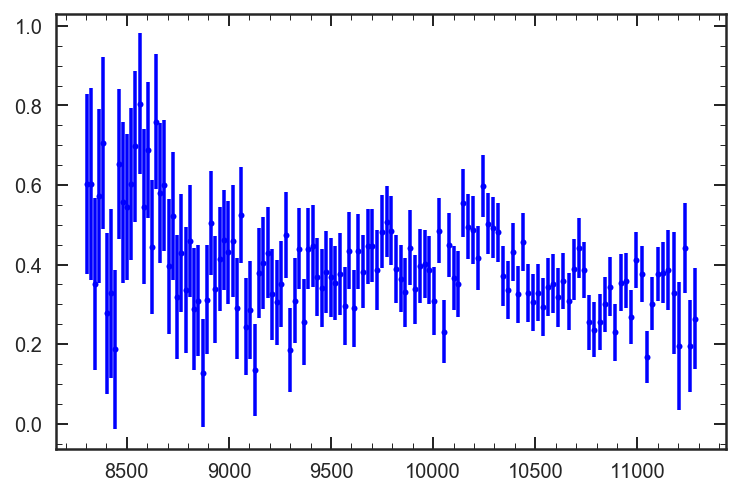

In [472]:
plt.errorbar(Gs.Bwv,Gs.Bfl*1E18, Gs.Ber*1E18,
            linestyle='None', marker='o', markersize=3, color='b', zorder = 2)
# plt.axvline(8700)
# plt.axvline(5176)

<ErrorbarContainer object of 3 artists>

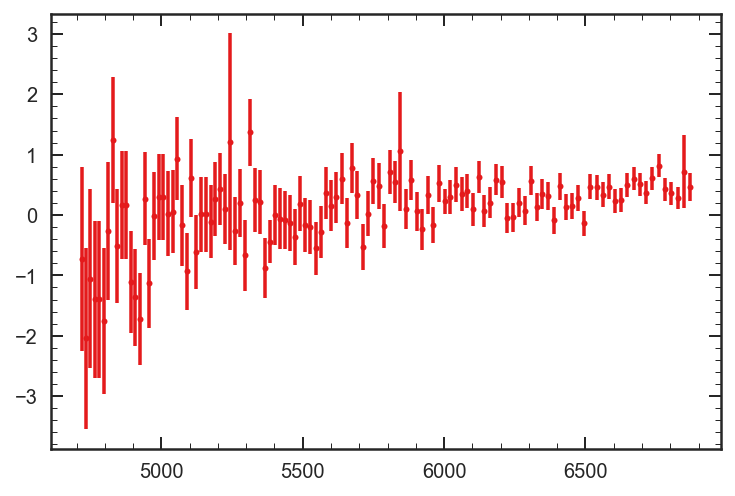

In [475]:
plt.errorbar(Gs.Rwv/2.4 ,Gs.Rfl*1E18, Gs.Rer*1E18,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
# plt.axvline(14000)

In [482]:
old_select = pd.read_pickle('../spec_files/section.pkl')
new_select = pd.read_pickle('../spec_files/new_section.pkl')

In [486]:
new_select['AGN'] = np.repeat('---', len(new_select))

In [498]:
zs = []

for i in new_select.index:
    if new_select.field[i] == 'GND':
        zs.append(GNdb.query('id == {0}'.format(new_select.id[i])).zphot.values[0])
    if new_select.field[i] == 'GSD':
        zs.append(GSdb.query('id == {0}'.format(new_select.id[i])).zphot.values[0])

In [500]:
new_select['zphot'] = zs

In [505]:
all_select = pd.concat([old_select,new_select], ignore_index=True)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [527]:
all_select.to_pickle('../spec_files/all_section.pkl')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


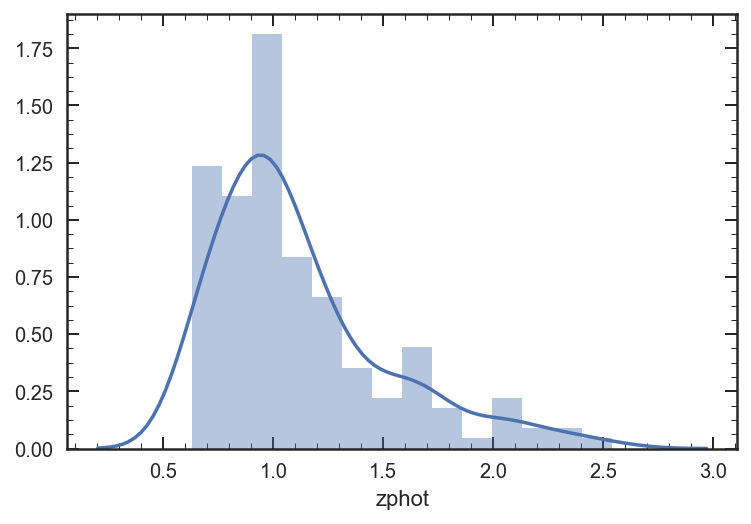

In [508]:
sea.distplot(all_select.query('AGN != "AGN" and use == True').zphot)

In [522]:
allzgrizli = []
for idx in all_select.index:
    if all_select.field[idx][1] == 'N':
        pre = 'N'
    else:
        pre = 'S'

    gid = all_select.id[idx]

    fp = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*'.format(pre, gid))

    subfields = [U.split('/')[-2] for U in fp]

    zgrizli = []

    for sb in subfields:
        dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(sb)), format='fits').to_pandas()

        zgrizli.append(dat.query('ID == {0}'.format(gid)).z_50.values[0])
        
    allzgrizli.append(zgrizli)

In [524]:
all_select['zgrizli'] = allzgrizli

In [2]:
all_select = pd.read_pickle('../spec_files/all_section.pkl')

In [14]:
def Plot_contam(field, galaxy, zgriz,savefig = False):
    try:
        m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
        bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
            '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))
        best = True
        z= [z]
    except:
        z=zgriz
        best = False

    for xx in range(len(z)):

        Gs = Gen_spec(field, galaxy, z[xx], g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
            phot_errterm = 0.04, irac_err = 0.08, decontam = False) 

        if best:
            sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
            sp.params['dust2'] = d
            sp.params['dust1'] = d
            sp.params['logzsol'] = np.log10(m)

            time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

            sp.set_tabular_sfh(time,sfr)    

            wave, flux = sp.get_spectrum(tage = a, peraa = True)    
            Gs.Best_fit_scale(wave, flux, z[xx], bp1, rp1, sp.stellar_mass, lm)


        plt.figure(figsize=[16,5])
        ###############plot tab##################

        if Gs.g102:
            IDCB = decontam_reg(Gs.Bwv, Gs.Ber, Gs.Bline, Gs.Bcont)
            plt.errorbar(Gs.Bwv_rf, Gs.Bfl *1E18, Gs.Ber *1E18,
                    linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 1)
            plt.errorbar(Gs.Bwv_rf[IDCB], Gs.Bfl[IDCB] *1E18, Gs.Ber[IDCB] *1E18,
                    linestyle='None', marker='o', markersize=3, color='k', zorder = 2)

        if Gs.g141:
            IDCR = decontam_reg(Gs.Rwv, Gs.Rer, Gs.Rline, Gs.Rcont)
            plt.errorbar(Gs.Rwv_rf,Gs.Rfl *1E18,Gs.Rer *1E18,
                    linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
            plt.errorbar(Gs.Rwv_rf[IDCR],Gs.Rfl[IDCR] *1E18,Gs.Rer[IDCR] *1E18,
                    linestyle='None', marker='o', markersize=3, color='k', zorder = 2)


        plt.axvline(3727.092,linestyle='--', alpha=.3)
        plt.axvline(4102.89,linestyle='--', alpha=.3, color = 'r')
        plt.axvline(4341.68,linestyle='--', alpha=.3, color = 'r')
        plt.axvline(4862.68,linestyle='--', alpha=.3, color = 'r')
        plt.axvline(5008.240,linestyle='--', alpha=.3)
        plt.axvline(6564.61,linestyle='--', alpha=.3, color = 'r')
        plt.axvline(6718.29,linestyle='--', alpha=.3, color = 'k')

        plt.title(field + str(galaxy), fontsize=25)
        plt.xlabel('Wavelength ($\AA$)', fontsize=20)
        plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
        plt.tick_params(axis='both', which='major', labelsize=15)

        if savefig:
            plt.savefig('../plots/contam/{0}_{1}_{2:1.4f}.png'.format(field, galaxy,z[xx]),bbox_inches = 'tight')

In [3]:
def decontam_reg(W, E, L, C):
    IDC = []
        
    for i in range(len(W)):
        if (C[i] + E[i]) > L[i]:
            IDC.append(i)

    return IDC

In [16]:
# for i in all_select.index:
#     Plot_contam(all_select.field[i], all_select.id[i], all_select.zgrizli[i], savefig=True)

In [ ]:
os.path.isfile()

# create mask

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


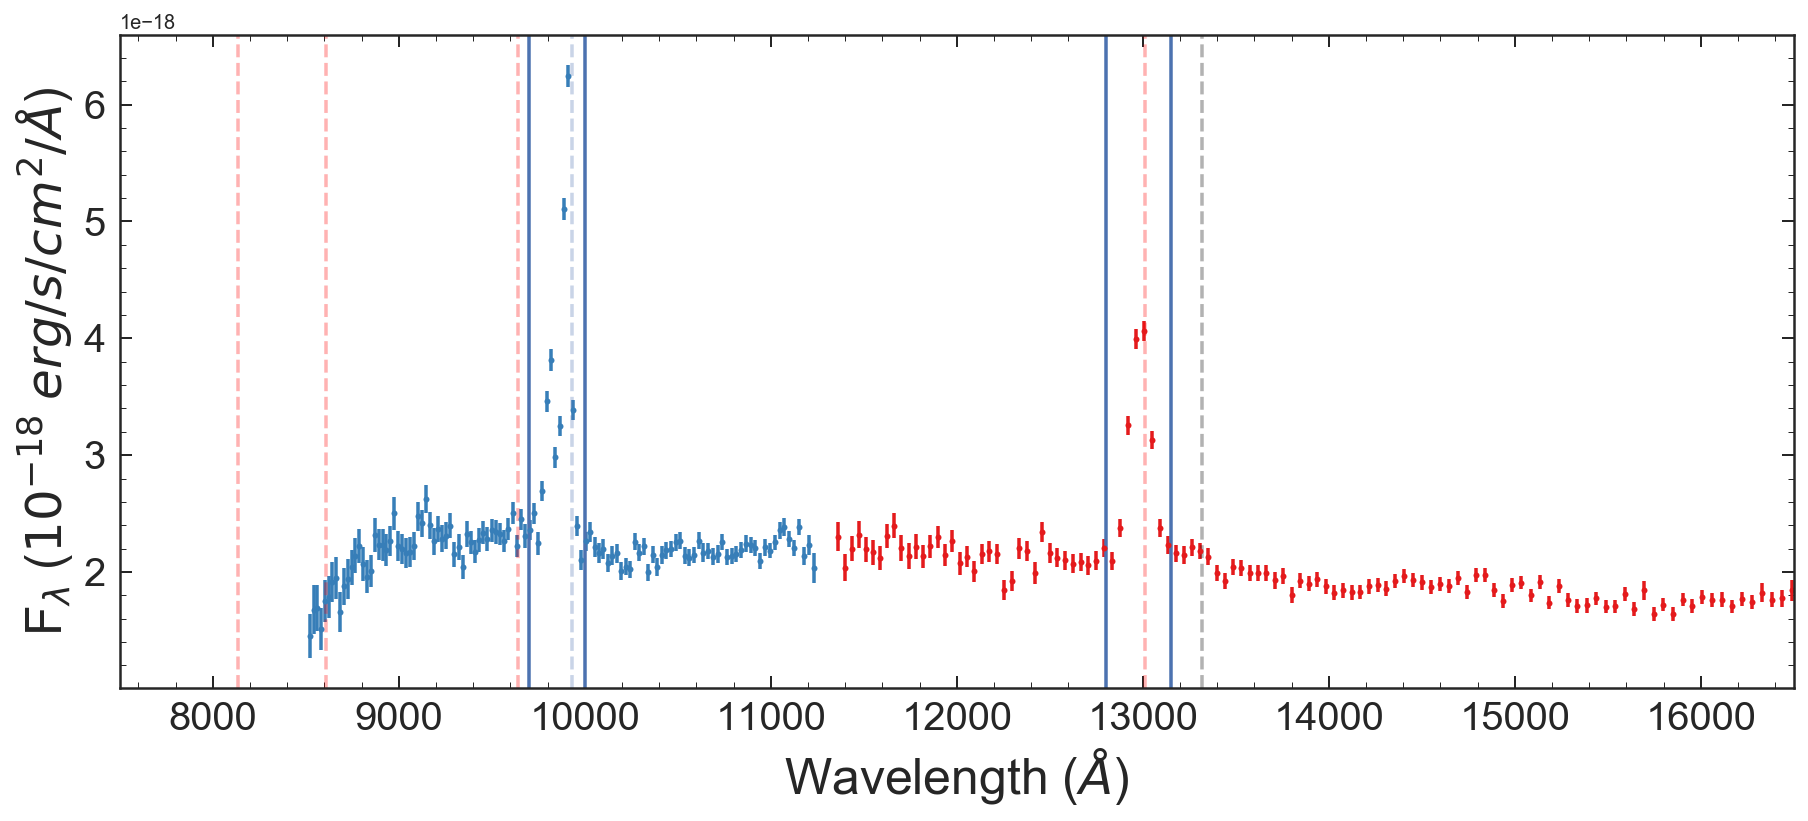

In [102]:
field = 'GSD'
galaxy = 45789

try:
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))
    best = True
    rshift = z
except:
    print(all_select.query('id == {0}'.format(galaxy)).zgrizli.values)
    rshift = all_select.query('id == {0}'.format(galaxy)).zgrizli.values[0][0]
    
    best = False
# rshift = 1.15
Gs = Gen_spec(field, galaxy, 1, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
    phot_errterm = 0.04, irac_err = 0.08, decontam = False,auto_select = True ) 

plt.figure(figsize = [15,6])
plt.errorbar(Gs.Bwv,Gs.Bfl,Gs.Ber,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(Gs.Rwv,Gs.Rfl,Gs.Rer,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')

plt.axvline(3727.092 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(4102.89 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(6564.61 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(6718.29 * (1 + rshift),linestyle='--', alpha=.3, color = 'k')

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(7500,16500)

plt.axvline(9700)
plt.axvline(10000)
plt.axvline(12800)
plt.axvline(13150)

mask = [[9700,10000],[12800,13150]]

IDMB = np.repeat(True, len(Gs.Bwv))
IDMR = np.repeat(True, len(Gs.Rwv))

for m in mask:
    for i in range(len(Gs.Bwv)):
        if m[0] < Gs.Bwv[i] < m[1]:
            IDMB[i] = False
    for i in range(len(Gs.Rwv)):
        if m[0] < Gs.Rwv[i] < m[1]:
            IDMR[i] = False
            
np.save('../spec_files/mask/{0}_{1}_mask'.format(field, galaxy), mask)

In [36]:
all_select.query('id == 36348')

,AGN,bhlim,bllim,field,id,rhlim,rllim,use,zphot,zgrizli
38,---,1.000000e+10,0,GND,36348,1.000000e+10,0,True,0.976412,[0.6378039709435321]


In [37]:
rshift

1.0088835976916184

(7500, 16500)

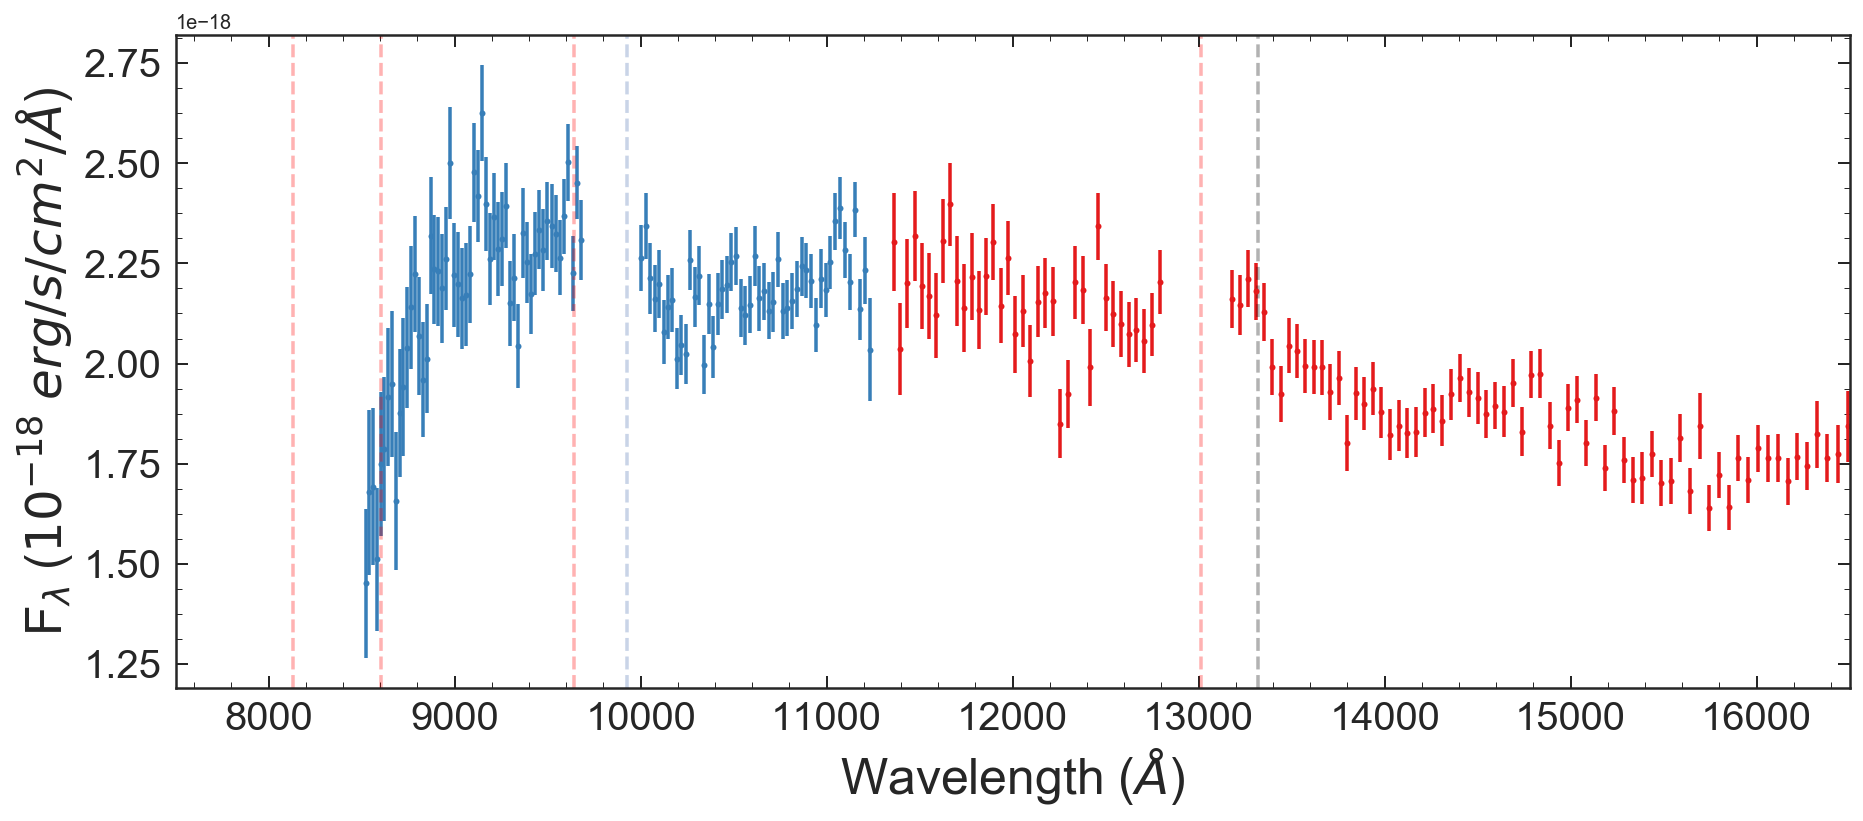

In [103]:
plt.figure(figsize = [15,6])
plt.errorbar(Gs.Bwv[IDMB],Gs.Bfl[IDMB],Gs.Ber[IDMB],
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(Gs.Rwv[IDMR],Gs.Rfl[IDMR],Gs.Rer[IDMR],
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')



plt.axvline(3727.092 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(4102.89 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(6564.61 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(6718.29 * (1 + rshift),linestyle='--', alpha=.3, color = 'k')

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(7500,16500)

[list([0.8607475852314306])]


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


(7500, 16500)

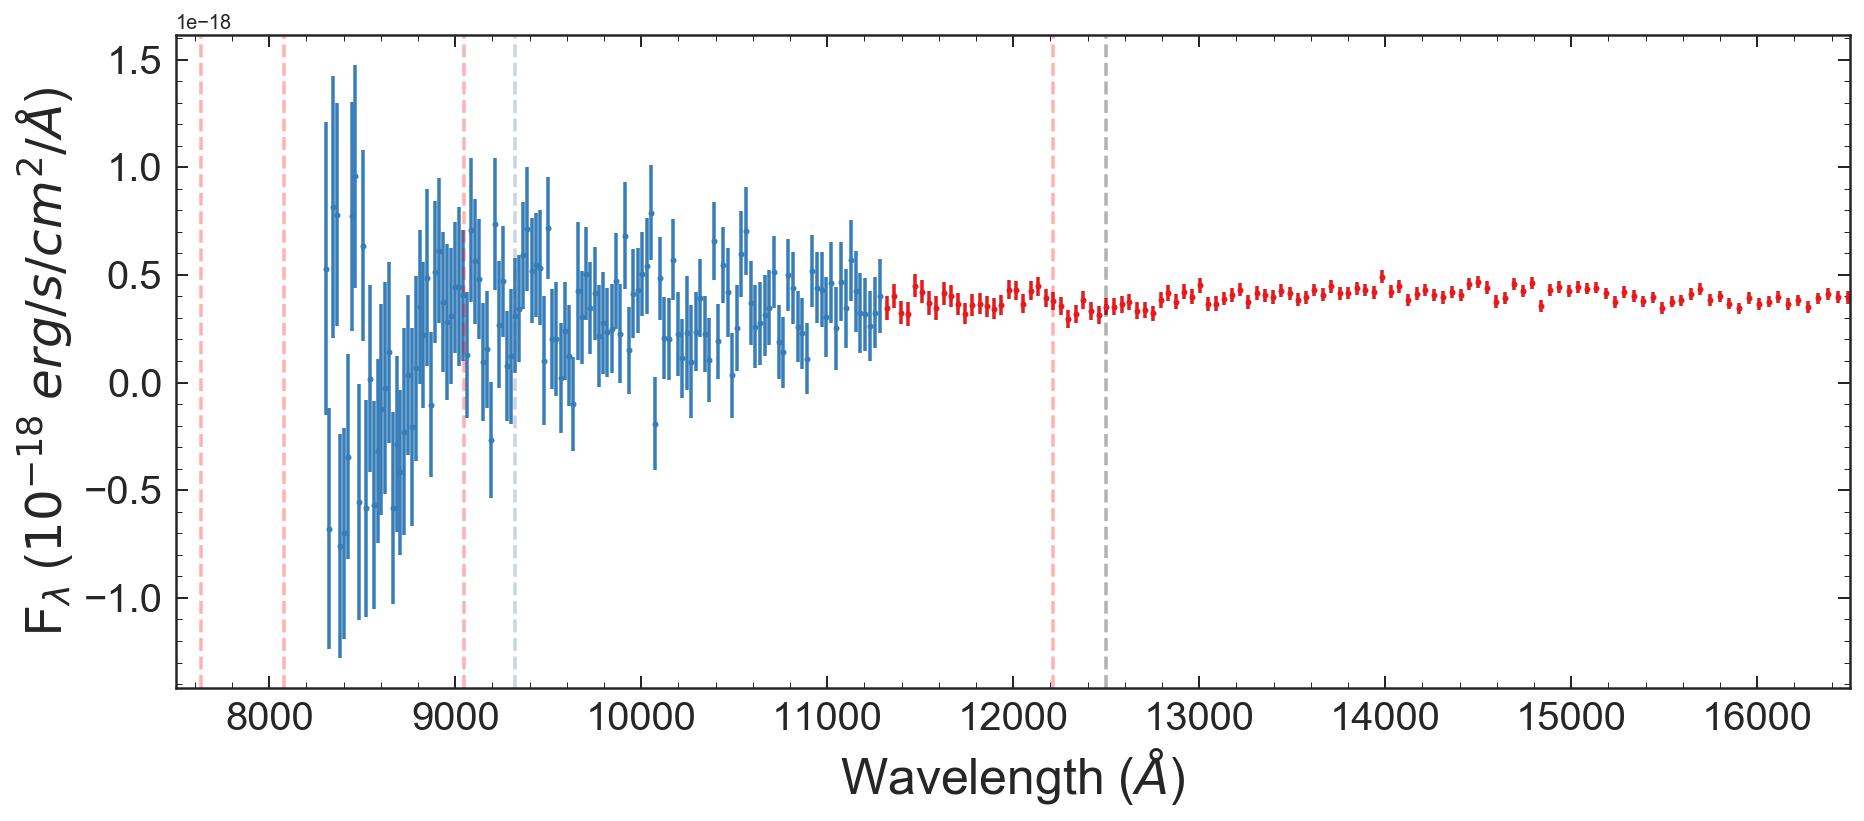

In [37]:
field = 'GND'
galaxy = 19442

try:
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))
    best = True
    rshift = z
except:
    print(all_select.query('id == {0}'.format(galaxy)).zgrizli.values)
    rshift = all_select.query('id == {0}'.format(galaxy)).zgrizli.values[0][0]
    
    best = False
Gs = Gen_spec(field, galaxy, 1, g102_lims=[8300, 11288], g141_lims=[11288, 16500],
    phot_errterm = 0.04, irac_err = 0.08) 

plt.figure(figsize = [15,6])
if Gs.g102:
    plt.errorbar(Gs.Bwv,Gs.Bfl,Gs.Ber,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
if Gs.g141:
    plt.errorbar(Gs.Rwv,Gs.Rfl,Gs.Rer,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')

plt.axvline(3727.092 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(4102.89 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(6564.61 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(6718.29 * (1 + rshift),linestyle='--', alpha=.3, color = 'k')

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(7500,16500)


In [47]:
glob(beam_path + '*{0}*g102*'.format(19442))

['../beams/o326.0_19442.g102.A.fits']

In [ ]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0,  sfh = 4, tau = 0.6, dust_type = 1)

model_wave, model_flux = sp.get_spectrum(tage = 3.6, peraa = True)

### set beams
BEAMS = []
TRANS = []

for i in beam:
    Beam = model.BeamCutout(fits_file = i)

    W, F = forward_model_grism(Beam, model_wave, np.ones(len(model_wave)))
    trans = interp1d(W,F)(wv)       

    BEAMS.append(Beam)
    TRANS.append(trans)

return BEAMS, TRANS

GND 17746
GND 19442
GND 20567
GND 21724
GND 22027
GND 22358
GND 22774
GND 32146
GND 32566
GND 32691
GND 32933
GND 33093
GSD 30566
GSD 30587
GSD 45128
GSD 46066
0


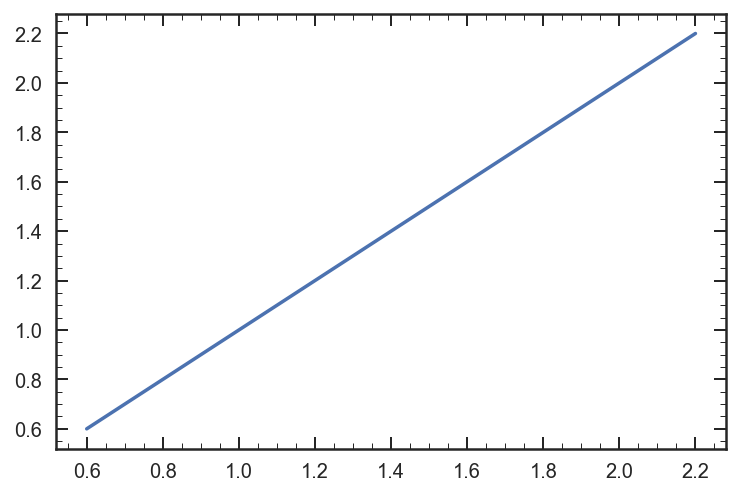

In [36]:
gselect = all_select.query('AGN != "AGN" and use == True')

u = 0
for i in gselect.index:
    try:
        x,px = np.load('../data/posteriors/{0}_{1}_zfit_Pz.npy'.format(gselect.field[i], gselect.id[i]))
#         if x[px == max(px)] < 0.7:
#             plt.plot(x,px)
#             u+=1
    except:
        print(gselect.field[i], gselect.id[i])
        
plt.plot([0.6,2.2],[0.6,2.2]) 
print(u)

In [13]:
len(glob('../data/posteriors/*zfit_bfit*'))

161

In [18]:
len(glob('../cluster_scripts/*zfit*'))

166

In [28]:
166 - 16 - 14

136

In [12]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

In [15]:
morph_db.query('Z < 0').id

77     12739
81     14132
86     16231
87     17746
90     19442
91     20567
93     21724
95     22027
97     22358
100    22774
110    32146
111    32566
112    32691
113    32933
114    33093
134    30566
135    30587
154    45128
156    46066
Name: id, dtype: int64

In [2]:
Gs = Gen_spec('GND', 19442, 1) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [3]:
Gs.g102,Gs.g141

(True, True)

In [4]:
Gs.g102_beam, Gs.g141_beam

(['../beams/o326.0_19442.g102.A.fits'], ['../beams/o345.0_39170.g141.A.fits'])

In [8]:

def PLOT_test(field, galaxy, savefig = False):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))
    
    Gs = Gen_spec(field, galaxy, z, phot_errterm = 0.04, irac_err = 0.08) 
    wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)    

    Gs.Best_fit_scale(wave, flux, z, bp1, rp1, sp.stellar_mass, lm)
    
    gs = GridSpec(3,4, hspace=0.3, wspace = 0.3)   

    plt.figure(figsize=[16,15])
    ###############plot tab##################
    plt.subplot(gs[0,:3])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.title(galaxy, fontsize=25)
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############sfh plot################
    med,le,he = np.zeros([3,10])
    for i in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(field, galaxy,i+1))
        med[i],le[i],he[i] = Highest_density_region(px,x)

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(field, galaxy))
    a,ale,ahe = Highest_density_region(px,x)

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    time, sfr_l, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
    time, sfr_h, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9) 
    
    plt.subplot(gs[0,3])
    plt.plot(time,sfr, 'r')
    plt.fill_between(time,sfr_l, sfr_h, alpha = 0.3)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('SFR', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############plot test################
    m, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_test_bfit.npy'.format(field, galaxy))
    a = Oldest_galaxy(z)
        
    Gs = Gen_spec(field, galaxy, z, phot_errterm = 0.04, irac_err = 0.08) 
    
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)    

    Gs.Best_fit_scale(wave, flux, z, bp1, rp1, sp.stellar_mass, lm)
    
    plt.subplot(gs[1,:3])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############sfh plot################
    med,le,he = np.zeros([3,10])
    for i in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_test_Pm{2}.npy'.format(field, galaxy,i+1))
        med[i],le[i],he[i] = Highest_density_region(px,x)

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    time, sfr_l, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
    time, sfr_h, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9) 
    
    plt.subplot(gs[1,3])
    plt.plot(time,sfr, 'r')
    plt.fill_between(time,sfr_l, sfr_h, alpha = 0.3)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('SFR', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(Z)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pm.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_tabfit_test_Pm.npy'.format(field, galaxy))
    
    plt.subplot(gs[2,0])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('Z / Z$_\odot$', fontsize=15)
    plt.ylabel('P(Z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(lwa)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_tabfit_test_Plwa.npy'.format(field, galaxy))

    plt.subplot(gs[2,1])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('P(lwa)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(z)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_tabfit_test_Pz.npy'.format(field, galaxy))
    
    plt.subplot(gs[2,2])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('redshift', fontsize=15)
    plt.ylabel('P(z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(d)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pd.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_tabfit_test_Pd.npy'.format(field, galaxy))
    
    plt.subplot(gs[2,3])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('Av', fontsize=15)
    plt.ylabel('P(Av)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    
    if savefig:
        plt.savefig('../plots/fullfits/all_data_{0}_{1}.png'.format(field, galaxy),bbox_inches = 'tight')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda

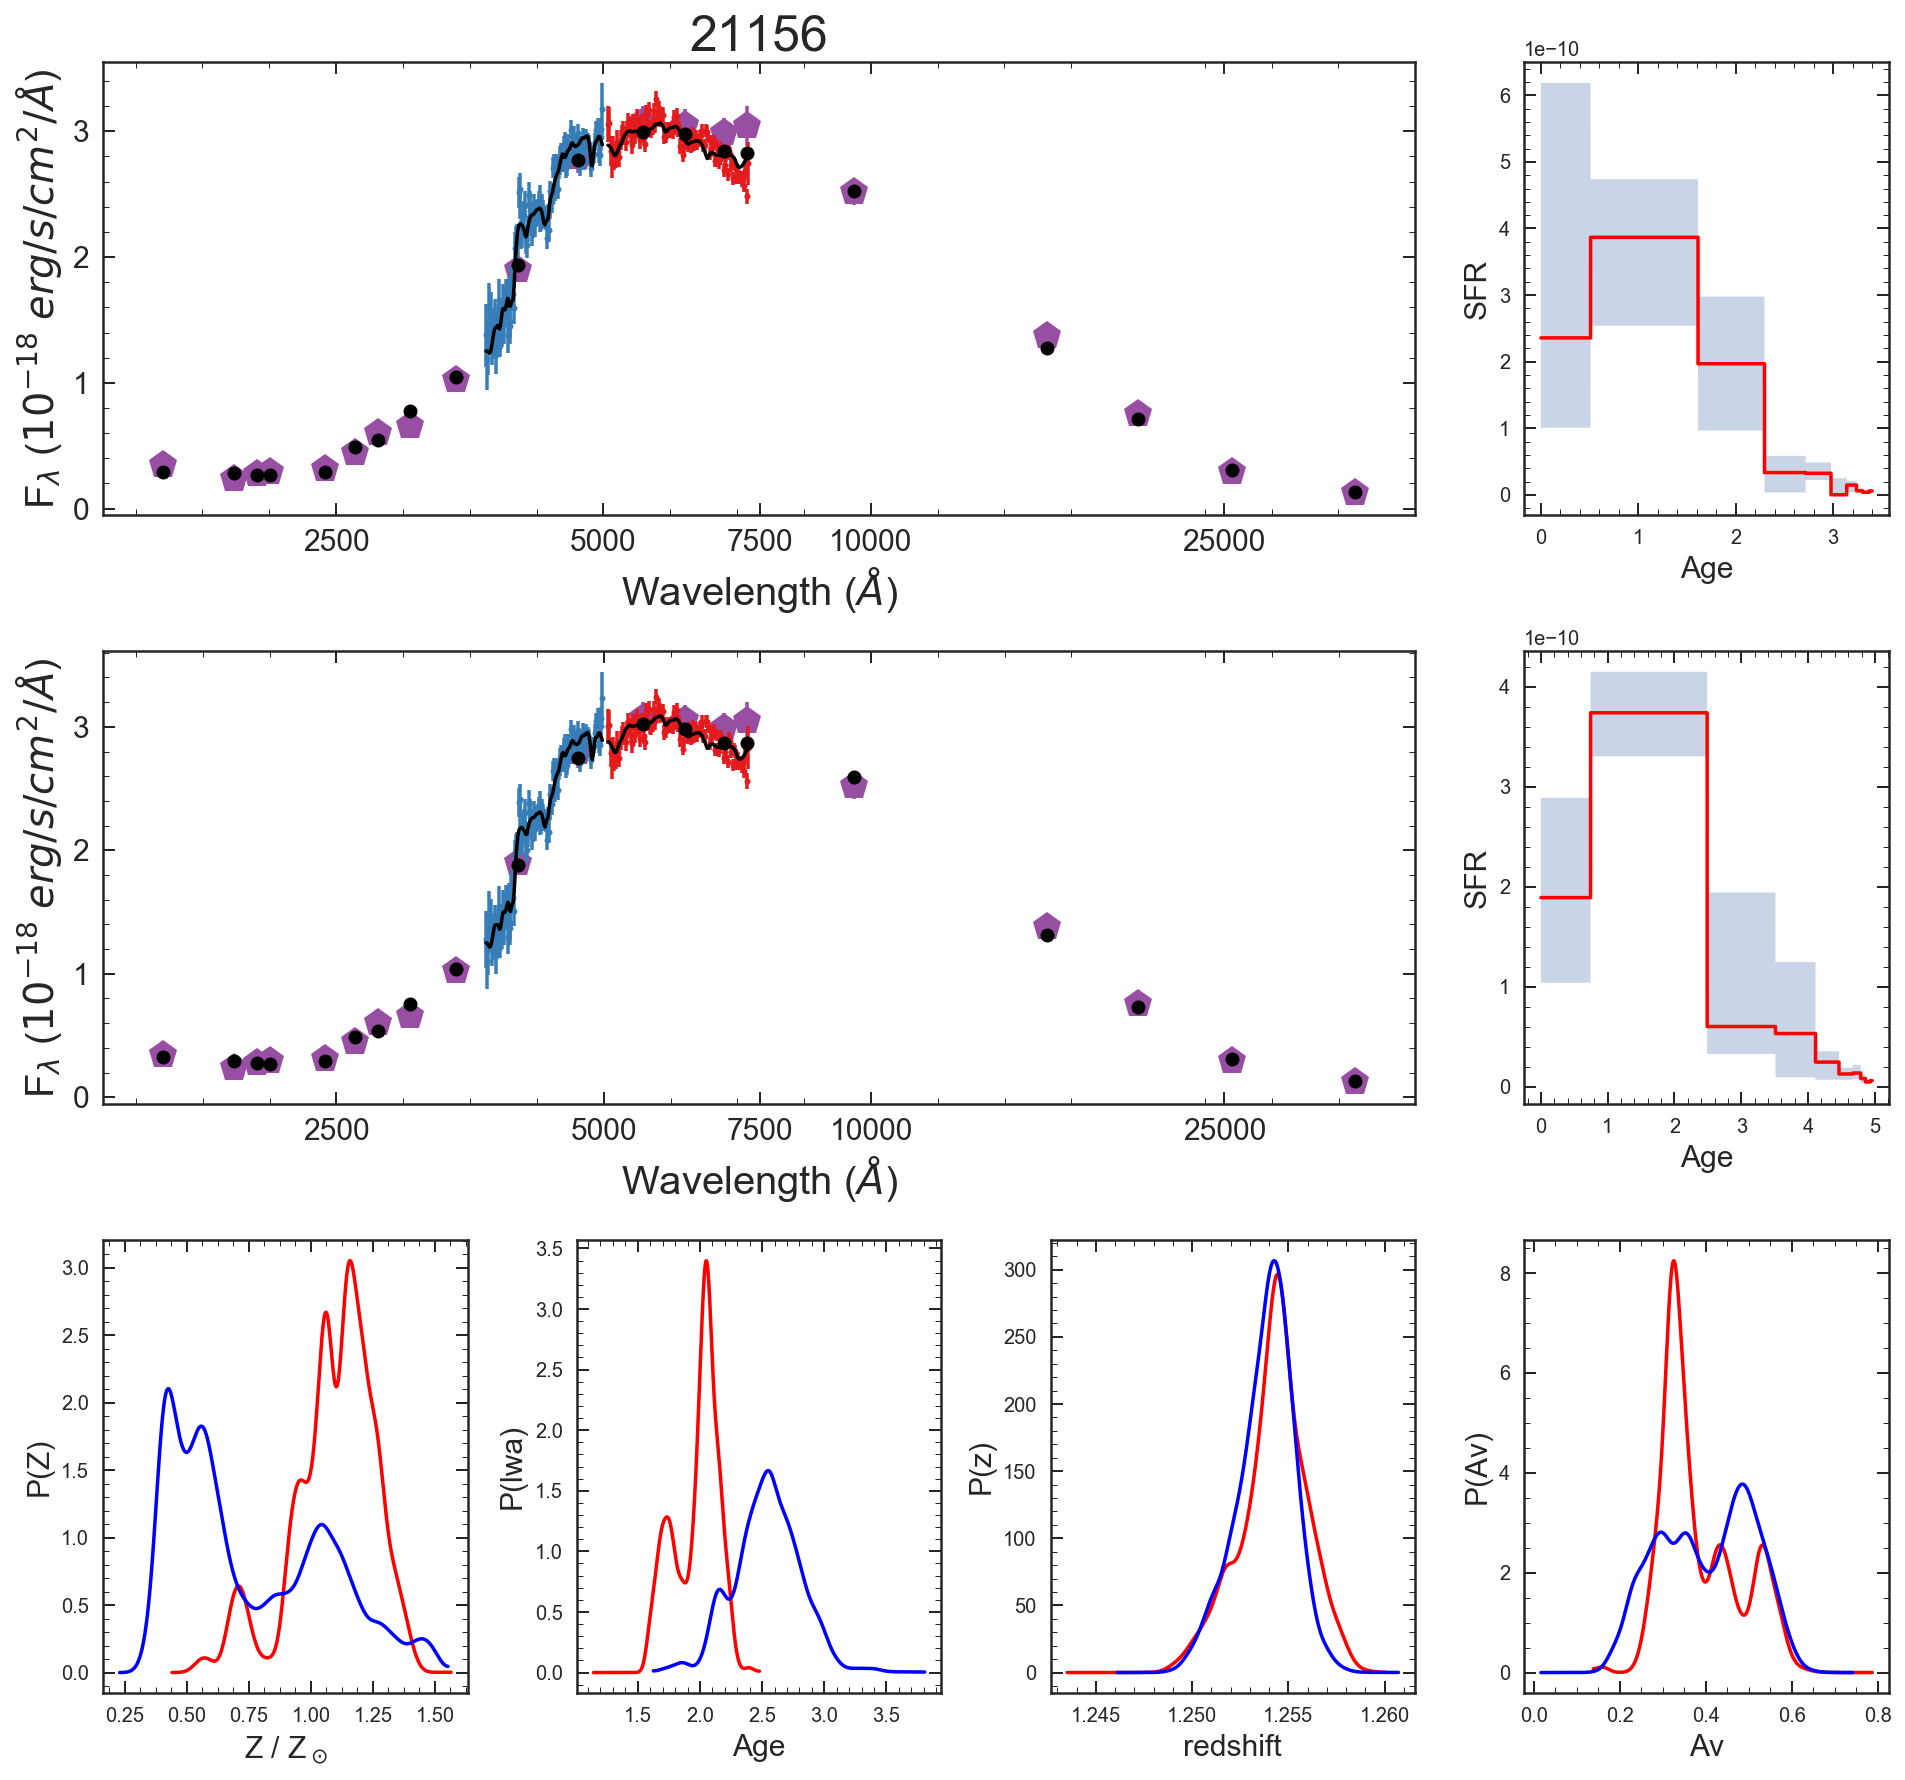

In [16]:
PLOT_test('GND',21156)